**Step 1: Data Cleansing and Pre-processing**

In [1]:

import pandas as pd

#loading the data
google_trends_data = pd.read_csv('monthly_main_category.csv')
gdp_data = pd.read_csv('Monthy_GDP_MI.csv')

print(google_trends_data.head())
print(gdp_data.head())

   Unnamed: 0        date  Arts & Entertainment  Autos & Vehicles  \
0           0  2004-01-01                     7                 5   
1           1  2004-02-01                     7                 8   
2           2  2004-03-01                     8                 7   
3           3  2004-04-01                     8                 9   
4           4  2004-05-01                     8                 7   

   Beauty & Fitness  Books & Literature  Business & Industrial  \
0                 7                  19                     18   
1                 7                  18                     18   
2                 8                  27                     26   
3                10                  29                     20   
4                 9                  26                     20   

   Computers & Electronics  Finance  Food & Drink  ...  News  \
0                       29        6             7  ...     8   
1                       34        4             7  ...     7

#Dropping unnecessary columns and Renaming columns in google_trends_data

In [2]:

google_trends_data = google_trends_data.drop(columns=["Unnamed: 0"])
gdp_data = gdp_data.drop(columns=["Unnamed: 0"])



gdp_data = gdp_data.rename(columns={"time": "date", "value": "GDP"})


# Convert date columns to datetime format

In [3]:

google_trends_data['date'] = pd.to_datetime(google_trends_data['date'])
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

# Filter google_trends_data to match GDP data's timeframe (2007 onward)

In [4]:

google_trends_data = google_trends_data[google_trends_data['date'] >= gdp_data['date'].min()]


# Check for missing values

In [5]:

print(google_trends_data.isnull().sum())
print(gdp_data.isnull().sum())

date                       0
Arts & Entertainment       0
Autos & Vehicles           0
Beauty & Fitness           0
Books & Literature         0
Business & Industrial      0
Computers & Electronics    0
Finance                    0
Food & Drink               0
Games                      0
Health                     0
Hobbies & Leisure          0
Home & Garden              0
Internet & Telecom         0
Jobs & Education           0
Law & Government           0
News                       0
Online Communities         0
People & Society           0
Pets & Animals             0
Real Estate                0
Reference                  0
Science                    0
Shopping                   0
Sports                     0
Travel                     0
dtype: int64
date    0
GDP     0
dtype: int64


In [6]:
merged_data = pd.merge(google_trends_data, gdp_data, on='date', how='inner')
merged_data.to_csv("merged_data.csv", index=False)


**Step 2: Correlation Analysis and Feature Selection**

In [7]:
correlation_matrix = merged_data.corr()
gdp_correlation = correlation_matrix["GDP"].sort_values(ascending=False)

print(gdp_correlation.head(10))

GDP                      1.000000
Health                   0.929105
Reference                0.924326
date                     0.920524
Business & Industrial    0.903274
Home & Garden            0.898296
Shopping                 0.873645
Real Estate              0.864225
Finance                  0.841132
Food & Drink             0.817749
Name: GDP, dtype: float64


Determining Best features using LASSO and elastic net

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import train_test_split
import numpy as np


X = merged_data.drop(columns=['GDP', 'date'])
y = merged_data['GDP']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LASSO
lasso_model = Lasso(alpha=0.1, max_iter=10000)
lasso_model.fit(X_train, y_train)
lasso_selected_features = X.columns[(lasso_model.coef_ != 0)]

# Elastic Net
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
elastic_net_model.fit(X_train, y_train)
elastic_net_selected_features = X.columns[(elastic_net_model.coef_ != 0)]

print("LASSO Selected Features:", lasso_selected_features)
print("Elastic Net Selected Features:", elastic_net_selected_features)


LASSO Selected Features: Index(['Arts & Entertainment', 'Autos & Vehicles', 'Books & Literature',
       'Business & Industrial', 'Computers & Electronics', 'Finance',
       'Food & Drink', 'Health', 'Hobbies & Leisure', 'Home & Garden',
       'Jobs & Education', 'Law & Government', 'News', 'Online Communities',
       'People & Society', 'Pets & Animals', 'Real Estate', 'Reference',
       'Science', 'Shopping', 'Sports', 'Travel'],
      dtype='object')
Elastic Net Selected Features: Index(['Arts & Entertainment', 'Beauty & Fitness', 'Business & Industrial',
       'Computers & Electronics', 'Finance', 'Food & Drink', 'Games', 'Health',
       'Hobbies & Leisure', 'Home & Garden', 'Internet & Telecom',
       'Jobs & Education', 'Law & Government', 'News', 'Online Communities',
       'Pets & Animals', 'Real Estate', 'Reference', 'Science', 'Sports'],
      dtype='object')


In [9]:
from sklearn.linear_model import Ridge

# Apply Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Display Ridge coefficients for all features
ridge_coefficients = ridge.coef_
ridge_features = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_coefficients})
ridge_features = ridge_features.sort_values(by='Coefficient', ascending=False)
print("Ridge Feature Coefficients:\n", ridge_features.head(10))


Ridge Feature Coefficients:
                Feature  Coefficient
11       Home & Garden    18.913274
9               Health    18.107352
20           Reference    17.383463
7         Food & Drink     6.004165
16  Online Communities     5.569921
19         Real Estate     4.047133
23              Sports     3.986402
8                Games     3.405092
18      Pets & Animals     3.302492
21             Science     3.193865


Checking feature importance

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Apply Random Forest Regressor and compute feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
rf_importances = rf.feature_importances_
rf_features = pd.DataFrame({'Feature': X.columns, 'Importance': rf_importances})
rf_features = rf_features.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:\n", rf_features.head(10))


Random Forest Feature Importances:
                   Feature  Importance
9                  Health    0.332244
20              Reference    0.197192
6                 Finance    0.188018
16     Online Communities    0.052793
19            Real Estate    0.051030
4   Business & Industrial    0.050253
11          Home & Garden    0.027010
0    Arts & Entertainment    0.011663
7            Food & Drink    0.009555
3      Books & Literature    0.009443


# **# Selected Features Summary:**
## LASSO Selected Features:

* Total Features: 21
* Notable Features: Arts & Entertainment, Health, Real Estate, Finance, and Sports.

## Elastic Net Selected Features:

* Total Features: 19
* Notable Features: Arts & Entertainment, Health, Business & Industrial, Finance, and Real Estate.

## Ridge Coefficients:

* The top features with coefficients:
1. Home & Garden (18.91)
2. Health (18.11)
3. Reference (17.38)
4. Food & Drink (6.00)
5. Online Communities (5.57)

## Random Forest Feature Importances:

* The top features based on importance scores:
1. Health (0.332)
2. Reference (0.197)
3. Finance (0.188)
4. Online Communities (0.052)




# **Step 2: Combine the Selected Features**
To build a final set of features for the nowcasting model, let’s take the features that appear most frequently across methods or have high importance/coefficients:

# Core Features to Include:
1. Health (selected by all)
2. Reference (selected by all)
3. Finance (selected by Random Forest and LASSO)
4. Online Communities (selected by Ridge and Random Forest)
5. Real Estate (selected by LASSO and Elastic Net)
6. Arts & Entertainment (selected by LASSO and Elastic Net)
7. Business & Industrial (selected by LASSO and Elastic Net)
8. Food & Drink (selected by LASSO and Ridge)

# **Step 3: Create a Final Data Set**

In [11]:

selected_features = [
    'Arts & Entertainment', 'Health', 'Reference', 'Finance',
    'Online Communities', 'Real Estate', 'Business & Industrial',
    'Food & Drink'
]

# Creating the final dataset with only selected features and GDP
final_dataset = merged_data[['date', 'GDP'] + selected_features]

# Checking the final dataset
print(final_dataset.head())

# Saving the final dataset
final_dataset.to_csv("final_dataset.csv", index=False)


        date         GDP  Arts & Entertainment  Health  Reference  Finance  \
0 2007-07-01  188.362251                    48      20         23       12   
1 2007-08-01  211.070833                    50      19         23       12   
2 2007-09-01  194.546916                    41      17         22       11   
3 2007-10-01  184.281476                    40      19         25       11   
4 2007-11-01  219.769682                    41      22         30       13   

   Online Communities  Real Estate  Business & Industrial  Food & Drink  
0                  16           17                     38            17  
1                  16           15                     34            17  
2                  15           15                     32            19  
3                  15           14                     34            18  
4                  14           17                     39            17  


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the final dataset
final_dataset = pd.read_csv("final_dataset.csv")

# Define features and target variable
X = final_dataset.drop(columns=['date', 'GDP'])
y = final_dataset['GDP']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(ols_model.summary())


Mean Squared Error: 248.14441599058446
R² Score: 0.8815964424892678
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     115.6
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           1.62e-54
Time:                        18:36:02   Log-Likelihood:                -569.00
No. Observations:                 136   AIC:                             1156.
Df Residuals:                     127   BIC:                             1182.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [13]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# Step 1: Calculate VIF for multicollinearity check
X = merged_data[selected_features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Step 2: Dimensionality Reduction with PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Step 3: Model Stacking
stacked_model = StackingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=1.0)),
        ('lasso', Lasso(alpha=0.1)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=0))
    ],
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=0)
)
stacked_model.fit(X_train, y_train)

# Step 4: Model Evaluation
kfold = KFold(n_splits=10)
cross_val_scores = cross_val_score(stacked_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -cross_val_scores.mean())




                 Feature         VIF
0   Arts & Entertainment   60.807258
1                 Health  253.157711
2              Reference  208.540820
3                Finance   24.755285
4     Online Communities   13.470407
5            Real Estate   51.984336
6  Business & Industrial  333.456561
7           Food & Drink   95.208096
Cross-validated MSE: 426.99368212601377


Augmenting the data with google Trends

In [14]:
import pandas as pd


gold_prices_df = pd.read_csv('gold_prices.csv', header=2)
car_market_df = pd.read_csv('car_market.csv', header=2)


print(gold_prices_df.head())
print(car_market_df.head())

# Renaming the columns to make them more descriptive
gold_prices_df.columns = ['Date', 'Gold_Prices_Search_Interest']
car_market_df.columns = ['Date', 'Car_Market_Search_Interest']

print(gold_prices_df.head())
print(car_market_df.head())

     Month  car_market
0  2007-07           1
1  2007-08           1
2  2007-09           0
3  2007-10           1
4  2007-11           3
     Month  car_market
0  2007-07           1
1  2007-08           1
2  2007-09           0
3  2007-10           1
4  2007-11           3
      Date  Gold_Prices_Search_Interest
0  2007-07                            1
1  2007-08                            1
2  2007-09                            0
3  2007-10                            1
4  2007-11                            3
      Date  Car_Market_Search_Interest
0  2007-07                           1
1  2007-08                           1
2  2007-09                           0
3  2007-10                           1
4  2007-11                           3


In [15]:
# Convert 'Date' column to datetime format
gold_prices_df['Date'] = pd.to_datetime(gold_prices_df['Date'], errors='coerce')
car_market_df['Date'] = pd.to_datetime(car_market_df['Date'], errors='coerce')

# Dropping rows with missing dates if any
gold_prices_df.dropna(subset=['Date'], inplace=True)
car_market_df.dropna(subset=['Date'], inplace=True)


print(gold_prices_df.head())
print(car_market_df.head())


        Date  Gold_Prices_Search_Interest
0 2007-07-01                            1
1 2007-08-01                            1
2 2007-09-01                            0
3 2007-10-01                            1
4 2007-11-01                            3
        Date  Car_Market_Search_Interest
0 2007-07-01                           1
1 2007-08-01                           1
2 2007-09-01                           0
3 2007-10-01                           1
4 2007-11-01                           3


In [16]:
combined_trends_df = pd.merge(gold_prices_df, car_market_df, on='Date', how='outer')

# Preview combined Google Trends data
print(combined_trends_df.head())

        Date  Gold_Prices_Search_Interest  Car_Market_Search_Interest
0 2007-07-01                            1                           1
1 2007-08-01                            1                           1
2 2007-09-01                            0                           0
3 2007-10-01                            1                           1
4 2007-11-01                            3                           3


In [17]:
final_dataset.rename(columns={'date': 'Date'}, inplace=True)
combined_trends_df.rename(columns={'date': 'Date'}, inplace=True)

# Ensuring that 'Date' columns are in datetime format in both DataFrames
final_dataset['Date'] = pd.to_datetime(final_dataset['Date'])
combined_trends_df['Date'] = pd.to_datetime(combined_trends_df['Date'])

merged_df = pd.merge(final_dataset, combined_trends_df, on='Date', how='left')

# Fill any missing values with 0
merged_df.fillna(0, inplace=True)

# Preview the final merged dataset
print(merged_df.head())

# saving this dataset for further modeling
merged_df.to_csv("merged_df.csv", index=False)

        Date         GDP  Arts & Entertainment  Health  Reference  Finance  \
0 2007-07-01  188.362251                    48      20         23       12   
1 2007-08-01  211.070833                    50      19         23       12   
2 2007-09-01  194.546916                    41      17         22       11   
3 2007-10-01  184.281476                    40      19         25       11   
4 2007-11-01  219.769682                    41      22         30       13   

   Online Communities  Real Estate  Business & Industrial  Food & Drink  \
0                  16           17                     38            17   
1                  16           15                     34            17   
2                  15           15                     32            19   
3                  15           14                     34            18   
4                  14           17                     39            17   

   Gold_Prices_Search_Interest  Car_Market_Search_Interest  
0                  

Linear Regression Model Evaluation on Merged Dataset: Performance Metrics and OLS Summary

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the final dataset
merged_df = pd.read_csv("merged_df.csv")

# Defining features and target variable
X = merged_df.drop(columns=['Date', 'GDP'])
y = merged_df['GDP']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Add a constant to the features for statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(ols_model.summary())


Mean Squared Error: 224.6325317618458
R² Score: 0.8928152753828066
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     103.0
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           9.92e-54
Time:                        18:36:20   Log-Likelihood:                -568.35
No. Observations:                 136   AIC:                             1157.
Df Residuals:                     126   BIC:                             1186.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

Variance Inflation Factor (VIF) Calculation for Feature Multicollinearity Assessment

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF DataFrame
print(vif_data)


                       Feature         VIF
0         Arts & Entertainment   67.225401
1                       Health  253.164301
2                    Reference  209.573406
3                      Finance   49.653024
4           Online Communities   13.490485
5                  Real Estate   53.899597
6        Business & Industrial  338.973662
7                 Food & Drink   99.946985
8  Gold_Prices_Search_Interest         inf
9   Car_Market_Search_Interest         inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Linear Regression Model Refinement by Removing Features with High Multicollinearity

In [20]:
# Drop features with high multicollinearity
X_reduced = X.drop(columns=['Gold_Prices_Search_Interest', 'Car_Market_Search_Interest', 'Health', 'Reference', 'Business & Industrial'])


X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Fitting the linear regression model again
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train_reduced)

# Make predictions on the test set
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Evaluate the model
mse_reduced = mean_squared_error(y_test_reduced, y_pred_reduced)
r2_reduced = r2_score(y_test_reduced, y_pred_reduced)

print(f"Mean Squared Error (Reduced Model): {mse_reduced}")
print(f"R² Score (Reduced Model): {r2_reduced}")

# OLS summary
X_train_reduced_sm = sm.add_constant(X_train_reduced)
ols_model_reduced = sm.OLS(y_train_reduced, X_train_reduced_sm).fit()
print(ols_model_reduced.summary())


Mean Squared Error (Reduced Model): 344.37253489262656
R² Score (Reduced Model): 0.835680633483113
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     130.5
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           6.67e-49
Time:                        18:36:20   Log-Likelihood:                -590.69
No. Observations:                 136   AIC:                             1193.
Df Residuals:                     130   BIC:                             1211.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------

Visualizing Model Performance: Actual vs. Predicted GDP Scatter Plot

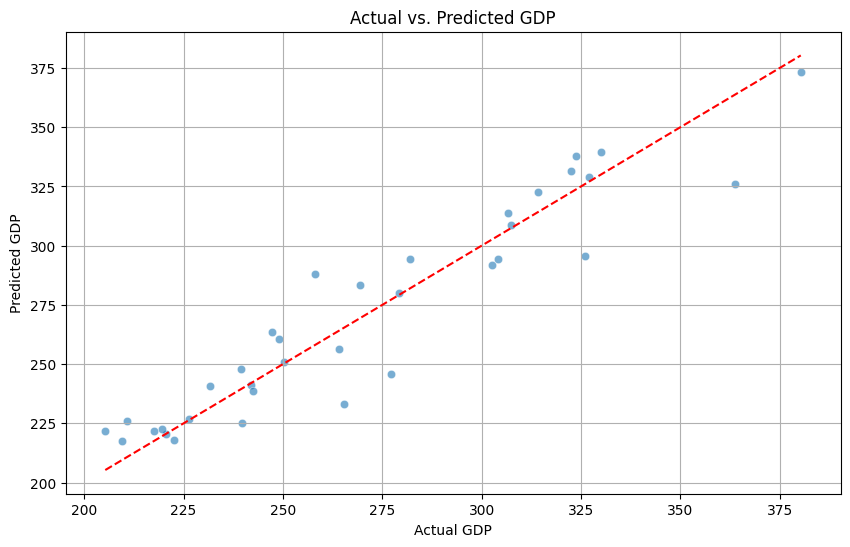

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine actual and predicted values into a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Actual GDP': y_test,
    'Predicted GDP': y_pred
})

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Actual GDP', y='Predicted GDP', alpha=0.6)

# Add a line for perfect predictions
plt.plot([results_df['Actual GDP'].min(), results_df['Actual GDP'].max()],
         [results_df['Actual GDP'].min(), results_df['Actual GDP'].max()],
         color='red', linestyle='--')

# Set the labels and title
plt.xlabel('Actual GDP')
plt.ylabel('Predicted GDP')
plt.title('Actual vs. Predicted GDP')
plt.xlim(results_df['Actual GDP'].min() - 10, results_df['Actual GDP'].max() + 10)
plt.ylim(results_df['Actual GDP'].min() - 10, results_df['Actual GDP'].max() + 10)
plt.grid()
plt.show()


Linear Regression Model Implementation on Final GDP Dataset: Training, Evaluation, and Performance Metrics

In [22]:
# Load the original final dataset (with all features)
final_dataset = pd.read_csv("final_dataset.csv")

# Define features and target variable
X = final_dataset.drop(columns=['date', 'GDP'])  # Include all features
y = final_dataset['GDP']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error and R² Score
mse_all = mean_squared_error(y_test, y_pred)
r2_all = r2_score(y_test, y_pred)

print(f"Mean Squared Error (All Features): {mse_all}")
print(f"R² Score (All Features): {r2_all}")


Mean Squared Error (All Features): 248.14441599058446
R² Score (All Features): 0.8815964424892678


Visualization of Actual vs. Predicted GDP Using Scatter Plot: Evaluation of Linear Regression Model Performance

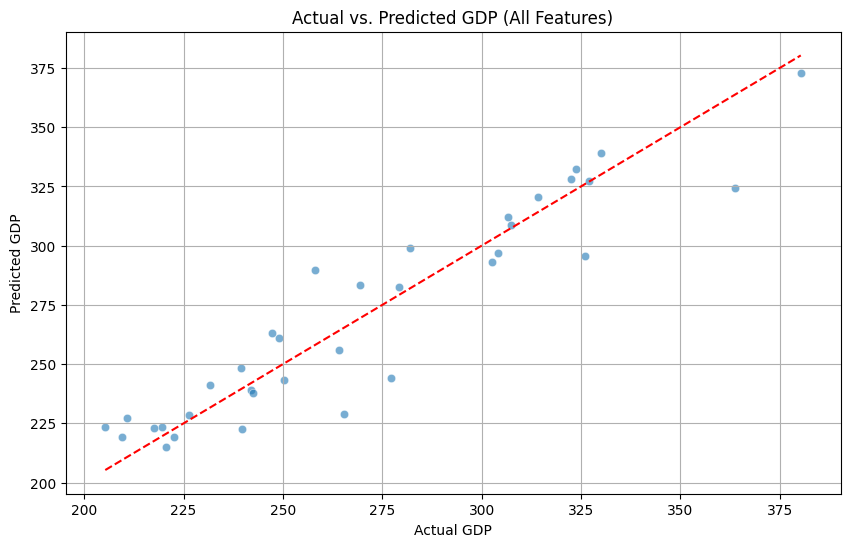

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine actual and predicted values into a DataFrame for easier plotting
results_df_all = pd.DataFrame({
    'Actual GDP': y_test,
    'Predicted GDP': y_pred
})

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_all, x='Actual GDP', y='Predicted GDP', alpha=0.6)

# Add a line for perfect predictions
plt.plot([results_df_all['Actual GDP'].min(), results_df_all['Actual GDP'].max()],
         [results_df_all['Actual GDP'].min(), results_df_all['Actual GDP'].max()],
         color='red', linestyle='--')

# Set the labels and title
plt.xlabel('Actual GDP')
plt.ylabel('Predicted GDP')
plt.title('Actual vs. Predicted GDP (All Features)')
plt.xlim(results_df_all['Actual GDP'].min() - 10, results_df_all['Actual GDP'].max() + 10)
plt.ylim(results_df_all['Actual GDP'].min() - 10, results_df_all['Actual GDP'].max() + 10)
plt.grid()
plt.show()


# Summary table for comparison

In [24]:
metrics_comparison = {
    'Model': ['Full Model', 'Reduced Model'],
    'Mean Squared Error': [mse_all, mse_reduced],
    'R² Score': [r2_all, r2_reduced],

}

metrics_df = pd.DataFrame(metrics_comparison)
print(metrics_df)


           Model  Mean Squared Error  R² Score
0     Full Model          248.144416  0.881596
1  Reduced Model          344.372535  0.835681


Evaluating Model Accuracy

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")


Mean Absolute Error: 11.964158024777715
Mean Squared Error: 248.14441599058446
R² Score: 0.8815964424892678
Mean Absolute Percentage Error: 4.452238559471698%


GDP Nowcasting Using SVM Regression with Hyperparameter Tuning

Mean Squared Error (SVM): 819.8144064496137
R² Score (SVM): 0.6088207673959232


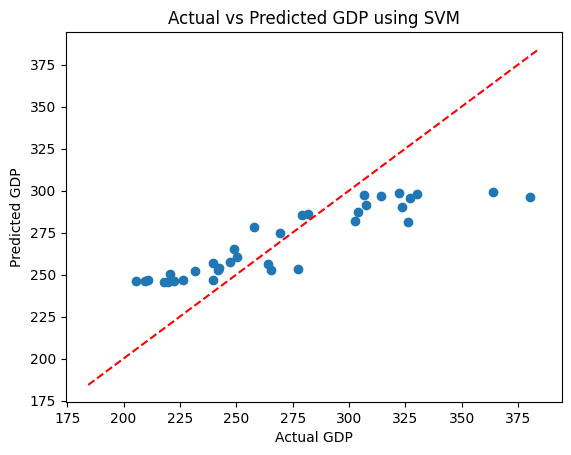

Best Parameters: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Mean Squared Error (SVM): 222.47453100778714
R² Score (SVM): 0.8938449780475688


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming merged_df is your DataFrame with features and target GDP
X = merged_df.drop(columns=['Date', 'GDP'])  # Adjust column names as needed
y = merged_df['GDP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Support Vector Regressor
svm_model = SVR(kernel='rbf')  # You can experiment with different kernels (linear, polynomial, etc.)

# Fit the model
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

# Calculate Mean Squared Error and R² Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (SVM): {mse}')
print(f'R² Score (SVM): {r2}')

plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual GDP')
plt.ylabel('Predicted GDP')
plt.title('Actual vs Predicted GDP using SVM')
plt.show()


# Scale the features and use SVR
pipeline = make_pipeline(StandardScaler(), SVR())

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.1, 1],
    'svr__kernel': ['linear', 'rbf', 'poly']
}

# Implement Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (SVM): {mse}")
print(f"R² Score (SVM): {r2}")


Optimizing Support Vector Regression (SVR) for GDP Prediction Using Grid Search Hyperparameter Tuning

In [29]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Scale the features and use SVR
pipeline = make_pipeline(StandardScaler(), SVR())

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.1, 1],
    'svr__kernel': ['linear', 'rbf', 'poly']
}

# Implement Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (SVM): {mse}")
print(f"R² Score (SVM): {r2}")


Best Parameters: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Mean Squared Error (SVM): 222.47453100778714
R² Score (SVM): 0.8938449780475688


Evaluating GDP Prediction Using a Random Forest Regressor Model

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Mean Squared Error (Random Forest): {rf_mse}")
print(f"R² Score (Random Forest): {rf_r2}")


Mean Squared Error (Random Forest): 289.32015672849207
R² Score (Random Forest): 0.8619491972871318


GDP Prediction Using Elastic Net Regression Model with Performance Evaluation

In [31]:
from sklearn.linear_model import ElasticNet

# Initialize and fit the model
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_net_model.fit(X_train, y_train)

# Make predictions
en_predictions = elastic_net_model.predict(X_test)

# Evaluate the model
en_mse = mean_squared_error(y_test, en_predictions)
en_r2 = r2_score(y_test, en_predictions)

print(f"Mean Squared Error (Elastic Net): {en_mse}")
print(f"R² Score (Elastic Net): {en_r2}")


Mean Squared Error (Elastic Net): 225.10487132236554
R² Score (Elastic Net): 0.8925898958025515


Model Comparison Table for GDP Prediction: SVM, Random Forest, and Elastic Net with Performance Metrics

In [32]:
import pandas as pd

# Store the results
results = {
    'Model': ['SVM', 'Random Forest', 'Elastic Net'],
    'Mean Squared Error': [222.47453100778714, rf_mse, en_mse],
    'R² Score': [0.8938449780475688, rf_r2, en_r2]
}

results_df = pd.DataFrame(results)
print(results_df)


           Model  Mean Squared Error  R² Score
0            SVM          222.474531  0.893845
1  Random Forest          289.320157  0.861949
2    Elastic Net          225.104871  0.892590


Support Vector Regression Pipeline for Final GDP Prediction: Model Fitting and Evaluation

In [33]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with scaling and SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(C=100, gamma='scale', kernel='linear'))
])

# Fit the model on the full dataset
svm_pipeline.fit(X, y)  # X and y from your final dataset
# Make predictions
predictions = svm_pipeline.predict(X)  # Use the same X for making predictions

# Calculate Mean Squared Error and R² Score
mse_final = mean_squared_error(y, predictions)
r2_final = r2_score(y, predictions)

print(f"Final Mean Squared Error (SVM): {mse_final}")
print(f"Final R² Score (SVM): {r2_final}")


Final Mean Squared Error (SVM): 250.48693096006897
Final R² Score (SVM): 0.8801112739141084
